<a href="https://colab.research.google.com/github/ankersp/thesis/blob/main/Gold_standard_model_evaluations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Loading libraries

In [1]:
# Install necessary libraries
!pip install transformers accelerate datasets --quiet
!pip install fsspec==2024.10.0 --quiet

# Import required libraries
import pandas as pd
from transformers import pipeline
from tqdm import tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 9.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.6/179.6 kB 2.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datasets 3.2.0 requires fsspec[http]<=2024.9.0,>=2023.1.0, but you have f

# Evaluation of ESG models

In [2]:
#Mount google drive
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import pandas as pd

# Specify the path to the file in Google Drive
file_path = '/content/drive/My Drive/KU/kandidat/speciale/R/annotated_200_eval.csv'
data = pd.read_csv(file_path, encoding='latin1')

print(data.columns)


Index(['id', 'text', 'Env_label.1...label..0...none',
       'Soc_label..1...label..0...none', 'Gov_label.1...label..0...none',
       'Sentiment..1...positive..0...negative', 'Action..1...label..0...none',
       'Future..1...label..0...none', 'doc_id', 'CVR', 'Year'],
      dtype='object')


In [ ]:

# Specify the paths to the fine-tuned models
env_model_path = "/content/drive/My Drive/KU/kandidat/speciale/R/finetuned_esgbert_env_model"
soc_model_path = "/content/drive/My Drive/KU/kandidat/speciale/R/finetuned_esgbert_soc_model"
gov_model_path = "/content/drive/My Drive/KU/kandidat/speciale/R/finetuned_esgbert_gov_model"
detector_model_path = "/content/drive/My Drive/KU/kandidat/speciale/R/finetuned_climatebert_detector_model"
climate_model_path = "/content/drive/My Drive/KU/kandidat/speciale/R/finetuned_climatebert_env_model"



# Load pipelines for each ESG model
env_pipeline = pipeline(
    'text-classification',
    model=env_model_path,
    tokenizer=env_model_path,
    device=0  # Use GPU if available; set to -1 for CPU
)

soc_pipeline = pipeline(
    'text-classification',
    model=soc_model_path,
    tokenizer=soc_model_path,
    device=0
)

gov_pipeline = pipeline(
    'text-classification',
    model=gov_model_path,
    tokenizer=gov_model_path,
    device=0
)

detector_pipeline = pipeline(
    'text-classification',
    model=detector_model_path,
    tokenizer=detector_model_path,
    device=0
)

climate_pipeline = pipeline(
    'text-classification',
    model=climate_model_path,
    tokenizer=climate_model_path,
    device=0
)



Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0


In [ ]:
# Function to classify ESG labels
def classify_all(data, env_pipeline, soc_pipeline, gov_pipeline, detector_pipeline, climate_pipeline):
    all_results = []

    for start_idx in tqdm(range(0, data.shape[0], 32), desc="Classifying with all models"):
        batch = data.iloc[start_idx:start_idx + 32]
        sentences = batch['text'].tolist()
        ids = batch['id'].tolist()

        # Classify batches for all models
        env_classifications = env_pipeline(sentences, padding=True, truncation=True)
        soc_classifications = soc_pipeline(sentences, padding=True, truncation=True)
        gov_classifications = gov_pipeline(sentences, padding=True, truncation=True)
        detector_classifications = detector_pipeline(sentences, padding=True, truncation=True)
        climate_classifications = climate_pipeline(sentences, padding=True, truncation=True)

        for i in range(len(sentences)):
            row_data = {
                "id": ids[i],
                "text": sentences[i],
                "env_label": env_classifications[i]["label"],
                "env_score": env_classifications[i]["score"],
                "soc_label": soc_classifications[i]["label"],
                "soc_score": soc_classifications[i]["score"],
                "gov_label": gov_classifications[i]["label"],
                "gov_score": gov_classifications[i]["score"],
                "detector_label": detector_classifications[i]["label"],
                "detector_score": detector_classifications[i]["score"],
                "climate_label": climate_classifications[i]["label"],
                "climate_score": climate_classifications[i]["score"],
            }
            all_results.append(row_data)

    return pd.DataFrame(all_results)

# Run classification
df_classified = classify_all(data, env_pipeline, soc_pipeline, gov_pipeline, detector_pipeline, climate_pipeline)

# Check the results
print(df_classified.head())

Classifying with all models: 100%|██████████| 7/7 [00:05<00:00,  1.20it/s]

       id                                               text env_label  \
0   36505  In order to protect the environment, we have s...   LABEL_1   
1   49557  We have reduced the consumption of packaging a...   LABEL_1   
2   48066  At the same time, we ensure that the items are...   LABEL_0   
3  159036  In 2018/2019 we have had focus on improvement ...   LABEL_1   
4  181901  The company changed to carbon-neutral wind pow...   LABEL_1   

   env_score soc_label  soc_score gov_label  gov_score detector_label  \
0   0.998402   LABEL_0   0.999503   LABEL_0   0.991039        LABEL_1   
1   0.994906   LABEL_0   0.999633   LABEL_0   0.995131        LABEL_1   
2   0.996501   LABEL_0   0.999024   LABEL_0   0.995756        LABEL_1   
3   0.998172   LABEL_0   0.999688   LABEL_0   0.848678        LABEL_1   
4   0.998543   LABEL_0   0.999544   LABEL_0   0.991528        LABEL_1   

   detector_score climate_label  climate_score  
0        0.996328       LABEL_1       0.995457  
1        0.996060 

## Gold standard evaluation

Classification report for Environmental saved to: /content/drive/My Drive/KU/kandidat/speciale/R/esg_evaluation_metrics/Environmental_classification_report.csv
Confusion matrix for Environmental saved to: /content/drive/My Drive/KU/kandidat/speciale/R/esg_evaluation_metrics/Environmental_confusion_matrix.csv


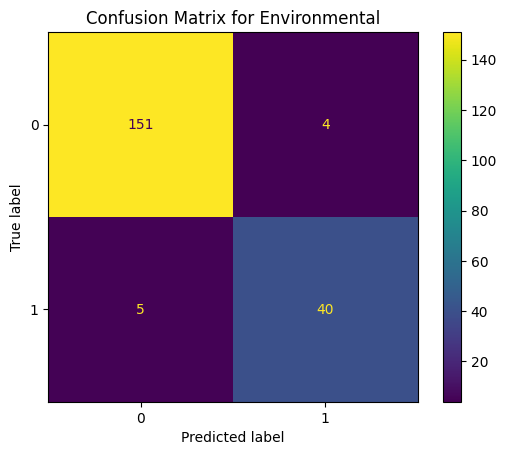

Classification report for Climate saved to: /content/drive/My Drive/KU/kandidat/speciale/R/esg_evaluation_metrics/Climate_classification_report.csv
Confusion matrix for Climate saved to: /content/drive/My Drive/KU/kandidat/speciale/R/esg_evaluation_metrics/Climate_confusion_matrix.csv


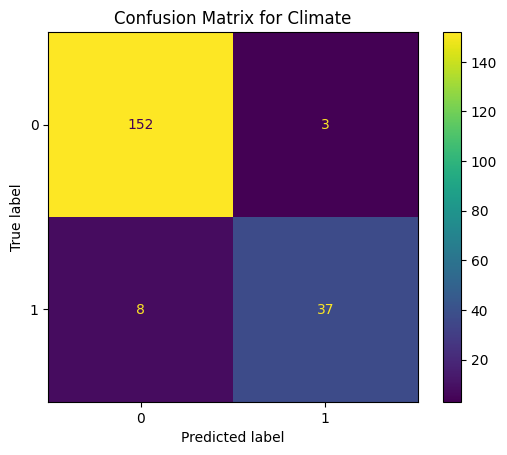

Classification report for Detector saved to: /content/drive/My Drive/KU/kandidat/speciale/R/esg_evaluation_metrics/Detector_classification_report.csv
Confusion matrix for Detector saved to: /content/drive/My Drive/KU/kandidat/speciale/R/esg_evaluation_metrics/Detector_confusion_matrix.csv


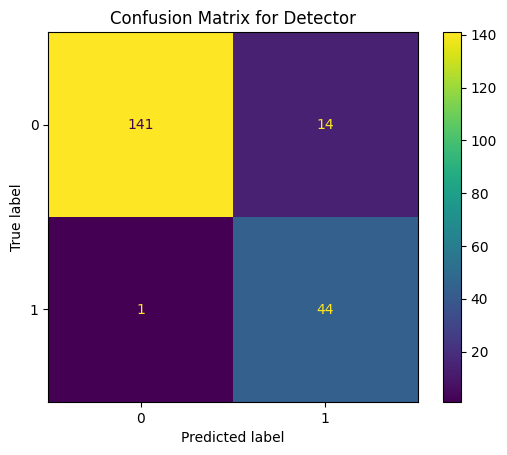

Classification report for Social saved to: /content/drive/My Drive/KU/kandidat/speciale/R/esg_evaluation_metrics/Social_classification_report.csv
Confusion matrix for Social saved to: /content/drive/My Drive/KU/kandidat/speciale/R/esg_evaluation_metrics/Social_confusion_matrix.csv


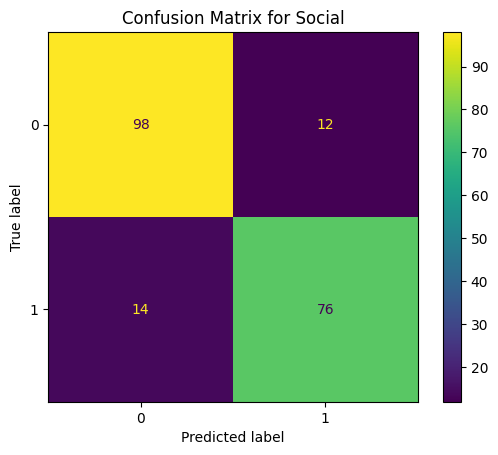

Classification report for Governance saved to: /content/drive/My Drive/KU/kandidat/speciale/R/esg_evaluation_metrics/Governance_classification_report.csv
Confusion matrix for Governance saved to: /content/drive/My Drive/KU/kandidat/speciale/R/esg_evaluation_metrics/Governance_confusion_matrix.csv


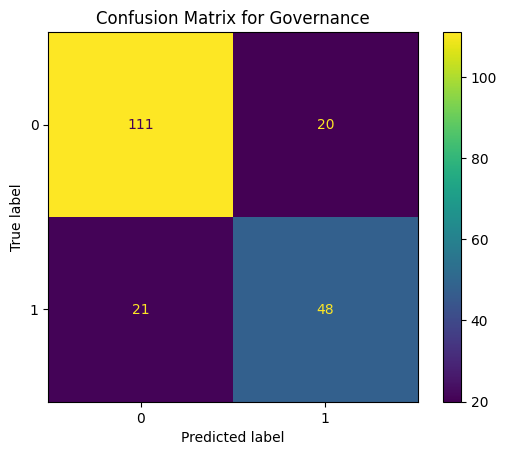

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import pandas as pd
import matplotlib.pyplot as plt

# Map predictions to numerical labels
label_mapping = {'LABEL_0': 0, 'LABEL_1': 1, 'LABEL_2': 2}

# Apply the label mapping to predicted columns
merged_data['env_label_pred'] = merged_data['env_label'].map(label_mapping)
merged_data['soc_label_pred'] = merged_data['soc_label'].map(label_mapping)
merged_data['gov_label_pred'] = merged_data['gov_label'].map(label_mapping)
merged_data['climate_label_pred'] = merged_data['climate_label'].map(label_mapping)
merged_data['detector_label_pred'] = merged_data['detector_label'].map(label_mapping)

# Extract gold and prediction labels for evaluation
env_gold = merged_data['Env_label.1...label..0...none']
env_pred = merged_data['env_label_pred']

soc_gold = merged_data['Soc_label..1...label..0...none']
soc_pred = merged_data['soc_label_pred']

gov_gold = merged_data['Gov_label.1...label..0...none']
gov_pred = merged_data['gov_label_pred']

climate_pred = merged_data['climate_label_pred']
detector_pred = merged_data['detector_label_pred']

# Function to evaluate and save metrics
def evaluate_and_export(gold, pred, label_name, output_dir):
    # Generate classification report
    report = classification_report(gold, pred, output_dict=True)
    report_df = pd.DataFrame(report).transpose()

    # Save classification report as a CSV file
    report_path = f"{output_dir}/{label_name}_classification_report.csv"
    report_df.to_csv(report_path, index=True)
    print(f"Classification report for {label_name} saved to: {report_path}")

    # Generate and save confusion matrix
    conf_mat = confusion_matrix(gold, pred)
    conf_matrix_path = f"{output_dir}/{label_name}_confusion_matrix.csv"
    pd.DataFrame(conf_mat).to_csv(conf_matrix_path, index=False, header=False)
    print(f"Confusion matrix for {label_name} saved to: {conf_matrix_path}")

    # Optionally display confusion matrix
    ConfusionMatrixDisplay(confusion_matrix=conf_mat).plot()
    plt.title(f"Confusion Matrix for {label_name}")
    plt.show()

# Directory to save the metrics
output_dir = "/content/drive/My Drive/KU/kandidat/speciale/R/esg_evaluation_metrics"

# Evaluate and export metrics for all models
evaluate_and_export(env_gold, env_pred, "Environmental", output_dir)
evaluate_and_export(env_gold, climate_pred, "Climate", output_dir)
evaluate_and_export(env_gold, detector_pred, "Detector", output_dir)
evaluate_and_export(soc_gold, soc_pred, "Social", output_dir)
evaluate_and_export(gov_gold, gov_pred, "Governance", output_dir)


# Evaluation of action, specificity and sentiment models

In [ ]:
import pandas as pd

# Specify the path to the file in Google Drive
file_path = '/content/drive/My Drive/KU/kandidat/speciale/R/env_annotated_500_eval.csv'
data = pd.read_csv(file_path, encoding='latin1')

print(data.columns)


Index(['id', 'text', 'Action..1.yes', 'Specific..1...yes',
       'Sentiment..risk...0..neutral..1..opportunity...2', 'doc_id', 'CVR',
       'Year'],
      dtype='object')


In [ ]:

# Specify the paths to the fine-tuned models
sentiment_model_path = "/content/drive/My Drive/KU/kandidat/speciale/R/finetuned_climatebert_sentiment_model"
specific_model_path = "/content/drive/My Drive/KU/kandidat/speciale/R/finetuned_climatebert_specificity_model"
action_model_path = "/content/drive/My Drive/KU/kandidat/speciale/R/finetuned_esgbert_action_model"
commit_model_path = "/content/drive/My Drive/KU/kandidat/speciale/R/finetuned_climatebert_action_model"


# Load pipelines for each model
sentiment_pipeline = pipeline(
    'text-classification',
    model=sentiment_model_path,
    tokenizer=sentiment_model_path,
    device=0
)

specific_pipeline = pipeline(
    'text-classification',
    model=specific_model_path,
    tokenizer=specific_model_path,
    device=0
)

action_pipeline = pipeline(
    'text-classification',
    model=action_model_path,
    tokenizer=action_model_path,
    device=0
)

commit_pipeline = pipeline(
    'text-classification',
    model=commit_model_path,
    tokenizer=commit_model_path,
    device=0
)

Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0


In [ ]:
# Function to classify using the new pipelines
def classify_all(data, sentiment_pipeline, specific_pipeline, action_pipeline, commit_pipeline):
    all_results = []

    for start_idx in tqdm(range(0, data.shape[0], 32), desc="Classifying with all models"):
        batch = data.iloc[start_idx:start_idx + 32]
        sentences = batch['text'].tolist()
        ids = batch['id'].tolist()

        # Classify batches for all models
        sentiment_classifications = sentiment_pipeline(sentences, padding=True, truncation=True)
        specific_classifications = specific_pipeline(sentences, padding=True, truncation=True)
        action_classifications = action_pipeline(sentences, padding=True, truncation=True)
        commit_classifications = commit_pipeline(sentences, padding=True, truncation=True)

        for i in range(len(sentences)):
            row_data = {
                "id": ids[i],
                "text": sentences[i],
                "sentiment_label": sentiment_classifications[i]["label"],
                "sentiment_score": sentiment_classifications[i]["score"],
                "specific_label": specific_classifications[i]["label"],
                "specific_score": specific_classifications[i]["score"],
                "action_label": action_classifications[i]["label"],
                "action_score": action_classifications[i]["score"],
                "commit_label": commit_classifications[i]["label"],
                "commit_score": commit_classifications[i]["score"],
            }
            all_results.append(row_data)

    return pd.DataFrame(all_results)

# Run classification with the new pipelines
df_classified = classify_all(data, sentiment_pipeline, specific_pipeline, action_pipeline, commit_pipeline)

# Check the results
print(df_classified.head())


Classifying with all models: 100%|██████████| 4/4 [00:05<00:00,  1.29s/it]

       id                                               text sentiment_label  \
0  195795  We take nature seriouslyNature is not just a p...         LABEL_1   
1   90467  The Group consider its effort to meet local la...         LABEL_1   
2  114040            Environmental legislative regulations2.         LABEL_1   
3   29695  Future improvements In the coming years, we wi...         LABEL_1   
4     100  We take it very seriously and therefore set th...         LABEL_1   

   sentiment_score specific_label  specific_score action_label  action_score  \
0         0.749736        LABEL_0        0.998447      LABEL_0      0.995808   
1         0.984098        LABEL_0        0.998865      LABEL_0      0.998818   
2         0.983275        LABEL_0        0.998057      LABEL_0      0.997641   
3         0.992289        LABEL_0        0.998398      LABEL_1      0.994003   
4         0.975865        LABEL_0        0.998500      LABEL_0      0.975754   

  commit_label  commit_score  
0      

## Gold standard evaluation

Classification report for Sentiment saved to: /content/drive/My Drive/KU/kandidat/speciale/R/esg_evaluation_metrics/Sentiment_classification_report.csv
Confusion matrix for Sentiment saved to: /content/drive/My Drive/KU/kandidat/speciale/R/esg_evaluation_metrics/Sentiment_confusion_matrix.csv


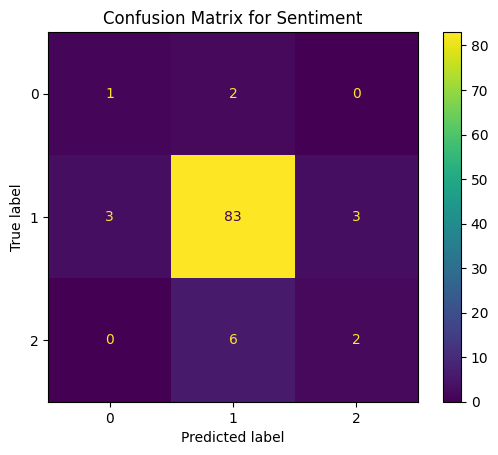

Classification report for Specificity saved to: /content/drive/My Drive/KU/kandidat/speciale/R/esg_evaluation_metrics/Specificity_classification_report.csv
Confusion matrix for Specificity saved to: /content/drive/My Drive/KU/kandidat/speciale/R/esg_evaluation_metrics/Specificity_confusion_matrix.csv


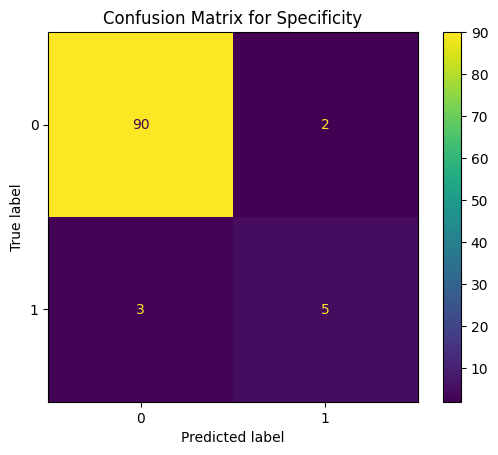

Classification report for Action saved to: /content/drive/My Drive/KU/kandidat/speciale/R/esg_evaluation_metrics/Action_classification_report.csv
Confusion matrix for Action saved to: /content/drive/My Drive/KU/kandidat/speciale/R/esg_evaluation_metrics/Action_confusion_matrix.csv


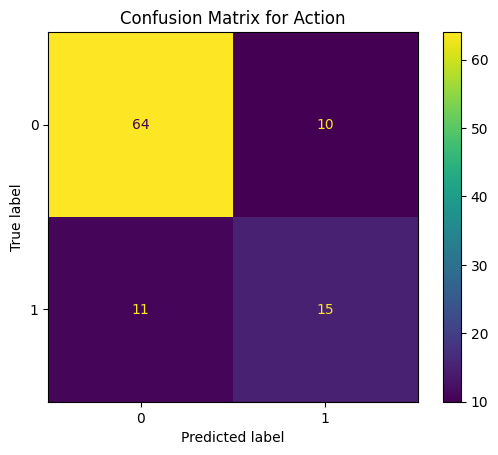

Classification report for Commit saved to: /content/drive/My Drive/KU/kandidat/speciale/R/esg_evaluation_metrics/Commit_classification_report.csv
Confusion matrix for Commit saved to: /content/drive/My Drive/KU/kandidat/speciale/R/esg_evaluation_metrics/Commit_confusion_matrix.csv


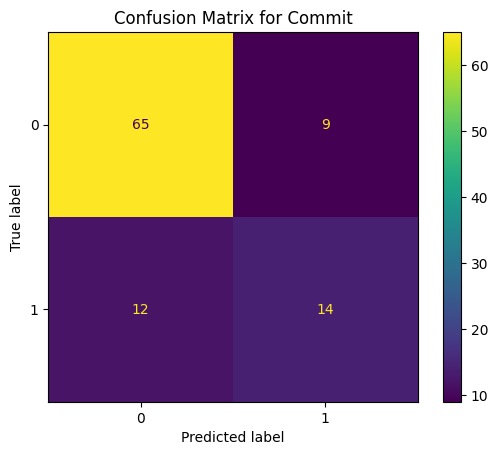

In [ ]:
# Map predictions to numerical labels
label_mapping = {'LABEL_0': 0, 'LABEL_1': 1, 'LABEL_2': 2}

# Ensure `df_classified` and `data` are aligned on `id`
merged_data = pd.merge(data, df_classified, on="id", suffixes=('_gold', '_pred'))

# Map predicted labels to numerical values
merged_data['sentiment_label_pred'] = merged_data['sentiment_label'].map(label_mapping)
merged_data['specific_label_pred'] = merged_data['specific_label'].map(label_mapping)
merged_data['action_label_pred'] = merged_data['action_label'].map(label_mapping)
merged_data['commit_label_pred'] = merged_data['commit_label'].map(label_mapping)


# Extract gold standard labels and predictions
sentiment_gold = merged_data['Sentiment..risk...0..neutral..1..opportunity...2']
sentiment_pred = merged_data['sentiment_label_pred']

specific_gold = merged_data['Specific..1...yes']
specific_pred = merged_data['specific_label_pred']

action_gold = merged_data['Action..1.yes']
action_pred = merged_data['action_label_pred']

commit_pred = merged_data['commit_label_pred']

# Function to evaluate and save metrics
def evaluate_and_export(gold, pred, label_name, output_dir):
    # Generate classification report
    report = classification_report(gold, pred, output_dict=True)
    report_df = pd.DataFrame(report).transpose()

    # Save classification report as a CSV file
    report_path = f"{output_dir}/{label_name}_classification_report.csv"
    report_df.to_csv(report_path, index=True)
    print(f"Classification report for {label_name} saved to: {report_path}")

    # Generate and save confusion matrix
    conf_mat = confusion_matrix(gold, pred)
    conf_matrix_path = f"{output_dir}/{label_name}_confusion_matrix.csv"
    pd.DataFrame(conf_mat).to_csv(conf_matrix_path, index=False, header=False)
    print(f"Confusion matrix for {label_name} saved to: {conf_matrix_path}")

    # Optionally display confusion matrix
    ConfusionMatrixDisplay(confusion_matrix=conf_mat).plot()
    plt.title(f"Confusion Matrix for {label_name}")
    plt.show()

# Directory to save the metrics
output_dir = "/content/drive/My Drive/KU/kandidat/speciale/R/esg_evaluation_metrics"

# Evaluate and export metrics for all models
evaluate_and_export(sentiment_gold, sentiment_pred, "Sentiment", output_dir)
evaluate_and_export(specific_gold, specific_pred, "Specificity", output_dir)
evaluate_and_export(action_gold, action_pred, "Action", output_dir)
evaluate_and_export(action_gold, commit_pred, "Commit", output_dir)



# Model comparisons

## ESG models

In [ ]:
import pandas as pd

# Paths to the classification reports
output_dir = "/content/drive/My Drive/KU/kandidat/speciale/R/esg_evaluation_metrics"
models = ["Environmental", "Social", "Governance", "Climate", "Detector"]

# Initialize summary DataFrame
summary_df = pd.DataFrame(columns=["Model", "Precision (weighted)", "Recall (weighted)", "F1-Score (weighted)", "Accuracy"])

# Load metrics and extract key scores
for model in models:
    report_path = f"{output_dir}/{model}_classification_report.csv"
    report = pd.read_csv(report_path, index_col=0)

    # Extract key metrics for weighted average
    weighted_precision = report.loc["weighted avg", "precision"]
    weighted_recall = report.loc["weighted avg", "recall"]
    weighted_f1 = report.loc["weighted avg", "f1-score"]
    accuracy = report.loc["accuracy", "precision"]  # Accuracy is stored here

    # Append to summary
    summary_df = pd.concat([summary_df, pd.DataFrame({
        "Model": [model],
        "Precision (weighted)": [weighted_precision],
        "Recall (weighted)": [weighted_recall],
        "F1-Score (weighted)": [weighted_f1],
        "Accuracy": [accuracy],
    })], ignore_index=True)

# Sort by F1-Score
summary_df = summary_df.sort_values(by="F1-Score (weighted)", ascending=False)

# Display summary
print(summary_df)

# Save summary to CSV
summary_df.to_csv(f"{output_dir}/esg_model_comparison_summary_weighted.csv", index=False)
print(f"Summary saved to: {output_dir}/esg_model_comparison_summary_weighted.csv")


           Model  Precision (weighted)  Recall (weighted)  \
0  Environmental              0.954706              0.955   
3        Climate              0.944375              0.945   
4       Detector              0.940232              0.925   
1         Social              0.869886              0.870   
2     Governance              0.794325              0.795   

   F1-Score (weighted)  Accuracy  
0             0.954820     0.955  
3             0.943819     0.945  
4             0.928092     0.925  
1             0.869855     0.870  
2             0.794642     0.795  
Summary saved to: /content/drive/My Drive/KU/kandidat/speciale/R/esg_evaluation_metrics/model_comparison_summary_weighted.csv


<ipython-input-45-a39c46b8bd90>:22: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  summary_df = pd.concat([summary_df, pd.DataFrame({


In [3]:
import pandas as pd

# Paths to the classification reports
output_dir = "/content/drive/My Drive/KU/kandidat/speciale/R/esg_evaluation_metrics"
models = ["Environmental", "Social", "Governance", "Climate", "Detector"]

# Initialize summary DataFrame
summary_df = pd.DataFrame(columns=["Model", "Precision (macro)", "Recall (macro)", "F1-Score (macro)", "Accuracy"])

# Load metrics and extract key scores
for model in models:
    report_path = f"{output_dir}/{model}_classification_report.csv"
    report = pd.read_csv(report_path, index_col=0)

    # Extract key metrics for macro average
    macro_precision = report.loc["macro avg", "precision"]
    macro_recall = report.loc["macro avg", "recall"]
    macro_f1 = report.loc["macro avg", "f1-score"]
    accuracy = report.loc["accuracy", "precision"]  # Accuracy is stored here

    # Append to summary
    summary_df = pd.concat([summary_df, pd.DataFrame({
        "Model": [model],
        "Precision (macro)": [macro_precision],
        "Recall (macro)": [macro_recall],
        "F1-Score (macro)": [macro_f1],
        "Accuracy": [accuracy],
    })], ignore_index=True)

# Sort by F1-Score
summary_df = summary_df.sort_values(by="F1-Score (macro)", ascending=False)

# Display summary
print(summary_df)

# Save summary to CSV
summary_df.to_csv(f"{output_dir}/esg_model_comparison_summary_macro.csv", index=False)
print(f"Summary saved to: {output_dir}/esg_model_comparison_summary_macro.csv")


<ipython-input-3-255d14bccf78>:22: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  summary_df = pd.concat([summary_df, pd.DataFrame({


           Model  Precision (macro)  Recall (macro)  F1-Score (macro)  \
0  Environmental           0.938520        0.931541          0.934969   
3        Climate           0.937500        0.901434          0.917834   
4       Detector           0.875789        0.943728          0.901932   
1         Social           0.869318        0.867677          0.868408   
2     Governance           0.773396        0.771490          0.772418   

   Accuracy  
0     0.955  
3     0.945  
4     0.925  
1     0.870  
2     0.795  
Summary saved to: /content/drive/My Drive/KU/kandidat/speciale/R/esg_evaluation_metrics/esg_model_comparison_summary_macro.csv


## Action, sentiment and specificity models

In [ ]:
import pandas as pd

# Paths to the classification reports
output_dir = "/content/drive/My Drive/KU/kandidat/speciale/R/esg_evaluation_metrics"
new_models = ["Sentiment", "Specificity", "Action", "Commit"]

# Initialize summary DataFrame
summary_df = pd.DataFrame(columns=["Model", "Precision (weighted)", "Recall (weighted)", "F1-Score (weighted)", "Accuracy"])

# Load metrics and extract key scores
for model in new_models:
    report_path = f"{output_dir}/{model}_classification_report.csv"
    report = pd.read_csv(report_path, index_col=0)

    # Extract key metrics
    weighted_precision = report.loc["weighted avg", "precision"]
    weighted_recall = report.loc["weighted avg", "recall"]
    weighted_f1 = report.loc["weighted avg", "f1-score"]
    accuracy = report.loc["accuracy", "precision"]  # Accuracy is stored here

    # Append to summary
    summary_df = pd.concat([summary_df, pd.DataFrame({
        "Model": [model],
        "Precision (weighted)": [weighted_precision],
        "Recall (weighted)": [weighted_recall],
        "F1-Score (weighted)": [weighted_f1],
        "Accuracy": [accuracy],
    })], ignore_index=True)

# Sort by F1-Score
summary_df = summary_df.sort_values(by="F1-Score (weighted)", ascending=False)

# Display summary
print(summary_df)

# Save summary to CSV
summary_df.to_csv(f"{output_dir}/extensive_model_comparison_summary_weighted.csv", index=False)
print(f"Summary saved to: {output_dir}/extensive_model_comparison_summary_weighted.csv")


         Model  Precision (weighted)  Recall (weighted)  F1-Score (weighted)  \
1  Specificity              0.947465               0.95             0.948468   
0    Sentiment              0.851258               0.86             0.853965   
2       Action              0.787467               0.79             0.788646   
3       Commit              0.782936               0.79             0.785658   

   Accuracy  
1      0.95  
0      0.86  
2      0.79  
3      0.79  
Summary saved to: /content/drive/My Drive/KU/kandidat/speciale/R/esg_evaluation_metrics/extensive_model_comparison_summary_weighted.csv


<ipython-input-46-658c99407086>:22: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  summary_df = pd.concat([summary_df, pd.DataFrame({


In [ ]:
import pandas as pd

# Paths to the classification reports
output_dir = "/content/drive/My Drive/KU/kandidat/speciale/R/esg_evaluation_metrics"
new_models = ["Sentiment", "Specificity", "Action", "Commit"]

# Initialize summary DataFrame
summary_df = pd.DataFrame(columns=["Model", "Precision (macro)", "Recall (macro)", "F1-Score (macro)", "Accuracy"])

# Load metrics and extract key scores
for model in new_models:
    report_path = f"{output_dir}/{model}_classification_report.csv"
    report = pd.read_csv(report_path, index_col=0)

    # Extract key metrics
    macro_precision = report.loc["macro avg", "precision"]
    macro_recall = report.loc["macro avg", "recall"]
    macro_f1 = report.loc["macro avg", "f1-score"]
    accuracy = report.loc["accuracy", "precision"]  # Accuracy is stored here

    # Append to summary
    summary_df = pd.concat([summary_df, pd.DataFrame({
        "Model": [model],
        "Precision (macro)": [macro_precision],
        "Recall (macro)": [macro_recall],
        "F1-Score (macro)": [macro_f1],
        "Accuracy": [accuracy],
    })], ignore_index=True)

# Sort by F1-Score
summary_df = summary_df.sort_values(by="F1-Score (macro)", ascending=False)

# Display summary
print(summary_df)

# Save summary to CSV
summary_df.to_csv(f"{output_dir}/extensive_model_comparison_summary_macro.csv", index=False)
print(f"Summary saved to: {output_dir}/extensive_model_comparison_summary_macro.csv")


         Model  Precision (macro)  Recall (macro)  F1-Score (macro)  Accuracy
1  Specificity           0.841014        0.801630          0.819820      0.95
2       Action           0.726667        0.720894          0.723648      0.79
3       Commit           0.726426        0.708420          0.716178      0.79
0    Sentiment           0.520696        0.505306          0.505210      0.86
Summary saved to: /content/drive/My Drive/KU/kandidat/speciale/R/esg_evaluation_metrics/extensive_model_comparison_summary_macro.csv


<ipython-input-47-d9dca0d8ae4b>:22: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  summary_df = pd.concat([summary_df, pd.DataFrame({
